<a href="https://colab.research.google.com/github/Andzo/sendy_logistics_challenge/blob/master/Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the CapeAI hackathon. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
%%html

<img src="https://media-exp1.licdn.com/dms/image/C4E1BAQHDfu7A5R2xMg/company-background_10000/0?e=2159024400&v=beta&t=wVPYGxoPMW6rZ8VoNasiXK4ZFp6_qtDtcs2XDIyCIeo", width=900,height=500>

# The Objective of this Challenge is to build a machine learning model that accurately predicts WHEN and WHERE the road incident will occur in Cape Town.

### You will build your models on historic road incident data as well as traffic pattern data from Uber, Sanral and other external sources.


## The resulting model will enable South African authorities to anticipate where they will be needed next and to put measures in place that will help ensure the safety of all Cape Town’s residents.

## There is all sorts of ways you can improve on the model shown here - the object is for this to be a starting point for anyone feeling like they don't know where to begin!

### Loading the data

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# I tend to first try to understand what the columns mean in the dataset.

variable_definitions = pd.read_csv("gdrive/My Drive/Zindi_Uber_hackathon/datasets/train_VariableDefinitions.csv")

variable_definitions # show all rows

,Variable name,Unnamed: 1
0,EventId,Unique ID of the incident
1,Occurrence Local Date Time,"Time incident occurred, Central African Time."
2,Reporting Agency,How was the incident reported or recognised
3,Cause,Incident type
4,Subcause,More information about the cause
5,Status,Closed or open
6,longitude,Lon and lat of the incident
7,latitude,NaN
8,road_segment_id,Segment of the road where the incident took pl...
9,isAccident,True or False


In [5]:
!dir

gdrive	sample_data


In [6]:
# We'll generate this later, so don't download it if you're in a hurry
sample_sub = pd.read_csv('gdrive/My Drive/Zindi_Uber_hackathon/datasets/SampleSubmission.csv');sample_sub.head()

,datetime x segment_id,prediction
0,2019-01-01 01:00:00 x S0B3CGQ,NaN
1,2019-01-01 01:00:00 x RYJYAPI,NaN
2,2019-01-01 01:00:00 x U3KP57C,NaN
3,2019-01-01 01:00:00 x RY0TRQ8,NaN
4,2019-01-01 01:00:00 x 8LOVJZ3,NaN


In [7]:
read = pd.read_csv("gdrive/My Drive/Zindi_Uber_hackathon/datasets/train_VariableDefinitions.csv")

read.head()

,Variable name,Unnamed: 1
0,EventId,Unique ID of the incident
1,Occurrence Local Date Time,"Time incident occurred, Central African Time."
2,Reporting Agency,How was the incident reported or recognised
3,Cause,Incident type
4,Subcause,More information about the cause


In [8]:
# Make sure train is in the folder where this notebook is running
data = pd.read_csv('gdrive/My Drive/Zindi_Uber_hackathon/datasets/train.csv', 
                   parse_dates = ['Occurrence Local Date Time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53845 entries, 0 to 53844
Data columns (total 9 columns):
EventId                       53845 non-null int64
Occurrence Local Date Time    53845 non-null datetime64[ns]
Reporting Agency              52226 non-null object
Cause                         53845 non-null object
Subcause                      53845 non-null object
Status                        53845 non-null object
longitude                     53845 non-null object
latitude                      53845 non-null float64
road_segment_id               53845 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 3.7+ MB


In [9]:
data["longitude"] = pd.to_numeric(data["longitude"],errors="coerce")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53845 entries, 0 to 53844
Data columns (total 9 columns):
EventId                       53845 non-null int64
Occurrence Local Date Time    53845 non-null datetime64[ns]
Reporting Agency              52226 non-null object
Cause                         53845 non-null object
Subcause                      53845 non-null object
Status                        53845 non-null object
longitude                     53840 non-null float64
latitude                      53845 non-null float64
road_segment_id               53845 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 3.7+ MB


In [10]:
data['road_segment_id'].unique().shape

(549,)

In [0]:
# there is a dataset called road_segment.zip. It contains geospatial data 
#Geospatial Analysis allows us to create interactive maps, and discover patterns in geospatial data

There are many, many different geospatial file formats, such as shapefile, GeoJSON, KML, and GPKG. We won't discuss their differences in this, but it's important to mention that:

 * shapefile (shp) is the most common file type that you'll encounter, and
 * all of these file types can be quickly loaded with the gpd.read_file() function.
 
This is will really help improve your model, if you play a bit around. I can send you some links on geopandas. Had some analysis done took it out because it would have made this easier for you! :(

In [12]:
!pip install geopandas

     |████████████████████████████████| 921kB 2.6MB/s 
     |████████████████████████████████| 11.8MB 18.6MB/s 
     |████████████████████████████████| 10.1MB 68.0MB/s 


In [13]:
import geopandas as gpd

#!pip install geopandas
# To install geopandas if you dont have it.
geo_data = gpd.read_file("gdrive/My Drive/Zindi_Uber_hackathon/datasets/road_segments.shp")

geo_data.head()

,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,segment_id,geometry
0,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,D1U6OOF,"LINESTRING (18.65262 -33.97724, 18.65264 -33.9..."
1,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,NG4X2MD,"LINESTRING (18.65347 -33.97309, 18.65347 -33.9..."
2,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,792705Z,"LINESTRING (18.65431 -33.96894, 18.65432 -33.9..."
3,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,IK67XHB,"LINESTRING (18.65515 -33.96480, 18.65517 -33.9..."
4,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,OWCF2MH,"LINESTRING (18.65600 -33.96065, 18.65602 -33.9..."


In [14]:
geo_data.segment_id.nunique()

552

In [15]:
geo_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 11 columns):
ROADNO        644 non-null object
CLASS         644 non-null object
REGION        644 non-null object
WIDTH         644 non-null float64
LANES         644 non-null int64
SURFTYPE      644 non-null object
PAVETYPE      644 non-null object
CONDITION     644 non-null object
length_1      644 non-null float64
segment_id    644 non-null object
geometry      644 non-null geometry
dtypes: float64(2), geometry(1), int64(1), object(7)
memory usage: 55.5+ KB


In [0]:
# lets plot where the condition, geometry, and segment

plot_data = geo_data.loc[:, ["CLASS", "CONDITION", "geometry","segment_id"]].copy()

In [17]:
plot_data.CONDITION.value_counts() #lets see how many good/bad  road conditions do we have. Maybe these influence the accidents

# Check this out later guys, don't want to give too much.

Very Good    331
Unknown      182
Good         115
Fair          16
Name: CONDITION, dtype: int64

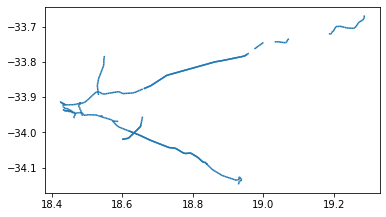

In [18]:
map_conditions = plot_data.loc[plot_data.CONDITION.isin(['Very Good', 'Unknown'])].copy() # compare the bad place to good 


map_conditions.plot()

# We want train and test arrays that match the sample submission.

### Don't bother reading too closely - check the output and move on. I did this so you don't have to!

First, we split by date. Here I'm using only 2017 for training, and part of 2018 for local testing.

In [0]:
# Train on 2017
train = data.loc[data['Occurrence Local Date Time'] < '2018-01-01']
train = train.loc[train['Occurrence Local Date Time'] >= '2017-01-01']

# Test locally on the last part of 2018
local_test = data.loc[data['Occurrence Local Date Time'] < '2019-01-01']
local_test = local_test.loc[local_test['Occurrence Local Date Time'] >= '2018-09-01']

Now we need to reshape these. 

In [20]:
# Create a dataframe with a column for each segment_id (sid)
# Each row represents an hour.

sids = data['road_segment_id'].unique()

dts = pd.date_range('2017-01-01',
                    '2018-01-01',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = train.loc[train['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
tr.head()

,datetime,S0B3CGQ,RYJYAPI,U3KP57C,RY0TRQ8,8LOVJZ3,X4UA382,0QR8FDW,DZABHQW,EKZN1VM,H9XYX9Q,03RHJ3G,FTX7LB8,Q03FQ74,5AC6YRF,1RWEBRU,DCB3LQM,HN83F3L,SPPGKO2,C1ERJ22,AJRKP0C,UUZT4OE,WAC029P,JT4HGZ2,8Z5P9T1,UAXX1ZE,74A6FL0,2M1UBKJ,E5D3KEB,NQSL7FX,S200A1J,ETFFDX5,R6JUSZT,EDXK0HP,N5NO82G,5DHNI4S,VUYACXV,VMCY8BI,927BHUF,3MW0MN9,...,SG89YSS,-34.0894652753,XYFQJ1Q,-33.9680008638,QTT8QNT,LC8FONX,WJXP54Z,GVQD9D6,64QSPWU,LRCHHQJ,Q2HCM1O,-33.8891283413,F055OA5,-34.0436786939,SY568EU,QBSA1OR,8YJIRQ2,KVOVDD8,H983665,7T2W8WU,4NSOFJG,4UAL23D,956JU5F,B8NRA4K,PH8DIYU,F47NAGJ,1NG8I9K,ZP9STNM,D3349RH,E4L0I98,YVR8GT6,ZAVM3PJ,DS4NLQE,HR19LL7,1451FOG,2ON8NSO,NFUEAN5,4T821GV,J6A19TW,43RCYZH
0,2017-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Reshape this as in sample submission
# I add some extra columns that may be useful
train = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
train.head()

In [0]:
# Same for local test (test from now on)
dts = pd.date_range('2018-09-01','2018-12-31',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = local_test.loc[local_test['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
    
test = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
test.head()

In [0]:
train.y.sum()

In [0]:
test.y.sum()

# Now that we have these, what features can we add?

All we have to go on is the date and segment ID. The shapefile of road segments has info on road type etc. We could get location for the segments, and use the uber movement data to add traffic speed for that area. Finally, we can do date-related values. I'll do the third first as it's a nice easy way to get something.

In [0]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['day'] = train['datetime'].dt.weekday

test['datetime'] = pd.to_datetime(test['datetime'])
test['day'] = test['datetime'].dt.weekday

In [0]:
train['min'] = train['datetime'].dt.hour*60+train['datetime'].dt.minute
train.head()

In [0]:
train.datetime[0].year

In [0]:
test['min'] = test['datetime'].dt.hour*60+test['datetime'].dt.minute
test.head()

In [0]:
locations = data.groupby("road_segment_id").mean()[['longitude','latitude']]
locations.dropna()

In [0]:
#locations = data.groupby('road_segment_id').mean()[['longitude', 'latitude']]
#locations.dropna

#locations.head(1)

In [0]:
train = pd.merge(train, locations, left_on='segment_id', right_on='road_segment_id')
train.head()



In [0]:
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id')
test.head()



In [0]:
train.fillna(0, inplace=True)
train.head()


In [0]:
test.fillna(0, inplace=True)
test.head()

In [0]:
train.datetime[38].hour

Cleaning up some things we don't need to save RAM

In [0]:
def get_year(dts):
    return dts.year

def get_month(dts):
    return dts.month

def get_day(dts):
    return dts.day

def get_hour(dts):
    return dts.hour

In [0]:
dts = train.datetime
train['year'] = list(map(get_year, dts))
train['month'] = list(map(get_month, dts))
train['day'] = list(map(get_day, dts))
train['hour'] = list(map(get_hour, dts))

In [0]:
dts = test.datetime
test['year'] = list(map(get_year, dts))
test['month'] = list(map(get_month, dts))
test['day'] = list(map(get_day, dts))
test['hour'] = list(map(get_hour, dts))

In [0]:
train.head()

In [0]:
train.iloc[4].datetime

In [0]:
data, local_test = 0, 0

# Creating and training a model

I like CatBoost because you don't have to do much to get a decent set of predictions. Categorical columns are easy to deal with and it doesn't take hours to train. THat said, use whatever you like here!

In [0]:
#!pip install catboost

In [0]:
train.head()

In [0]:
(train.datetime.min(), train.datetime.max())

In [0]:
test.head()

In [0]:
dummied_train = pd.get_dummies(train.drop('datetime x segment_id', axis=1), prefix='', prefix_sep='')
dummied_test = pd.get_dummies(test.drop('datetime x segment_id', axis=1), prefix='', prefix_sep='')
dummied_train.head()

In [0]:
remove_cols = ['datetime', 'longitude', 'latitude', '-33.8891283413', '-33.9622761744', '-33.9680008638', '-34.0436786939', '-34.0894652753']

In [0]:
from sklearn.ensemble import RandomForestClassifier

X_train = dummied_train.drop(remove_cols, axis=1)
X_test = dummied_test.drop(remove_cols, axis=1)
y_train = train.y
y_test = test.y

In [0]:
# rfc = RandomForestClassifier()
# rfc.fit(X_train,y_train)# predictions
# rfc_predict = rfc.predict(X_test)

In [0]:
# from sklearn.naive_bayes import GaussianNB

# gnb = GaussianNB()
# y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [0]:
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(random_state=0).fit(X_train, y_train).predict(X_test)

In [0]:
import torch, torchvision
from torch import nn
import torch.nn.functional as F
from torch import optim

In [0]:
trainloader = torch.utils.data.DataLoader(dummied_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dummied_test, batch_size=64, shuffle=True)

In [0]:
class Network(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.05):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of input
            output_size: integer, size of output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
    
    
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits'''
        
        # Forwardc through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x.dropout = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [0]:
dummied_train.shape

In [0]:
# create tghe network, define the criterion and optimizer
model = Network(input_size=558, output_size=1, hidden_layers=[229, 18])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
# The validation function
def validation(model, loader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in loader:
        images.resize_(images.shape[0], 784)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

Machine Learning Explainability - Permutation Importance and Partial Plots
One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?

This concept is called feature importance. There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.


permutation importance is:

 * fast to calculate,
 * widely used and understood, and
 * consistent with properties we would want a feature importance measure to have.


# How It Works
### Permutation importance uses models differently than anything you've seen so far, and many people find it confusing at first. So we'll start with an example to make it more concrete.


Consider data with the following format:


![image.png](attachment:image.png)
We want to predict a person's height when they become 20 years old, using data that is available at age 10.

Our data includes useful features (height at age 10), features with little predictive power (socks owned), as well as some other features we won't focus on in this explanation.

Permutation importance is calculated after a model has been fitted. So we won't change the model or change what predictions we'd get for a given value of height, sock-count, etc.

Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?


In [0]:

# %%html

# <img src="https://i.imgur.com/h17tMUU.png", width=900,height=500>

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions. In this case, shuffling height at age 10 would cause terrible predictions. If we shuffled socks owned instead, the resulting predictions wouldn't suffer nearly as much.

With this insight, the process is as follows:

* Get a trained model.
* Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
* Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

Code Example
Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game. Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model. 

Since I've built the demo model, lets get straight to the point.

oh you have to install eli5. ELI5 is a Python package which helps to debug machine learning classifiers and explain their predictions.

run "!pip install eli5"

In [0]:


from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(df[x_cols]))

# Imputation removed column names; put them back
imputed_X_train.columns = df[x_cols].columns


In [0]:
import eli5
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(model, random_state=1).fit(imputed_X_train, train['y'])
eli5.show_weights(perm, feature_names = imputed_X_train.columns.tolist())

In [0]:
# figure out how to deal with this one.
# The features that are most important are at the top, another hint. Check out different models and do some feature engineering.

# http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example

# Interpreting Permutation Importances
The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In [0]:
train[x_cols].head()

In [0]:
model.predict_proba(train[x_cols])[:, 1]

# Scoring the model

We'll start by looking at log-loss, then switch to trying to get a reasonable F1 score.

In [0]:
# Score the model on the train set
from sklearn.metrics import log_loss
log_loss(train['y'], model.predict_proba(train[x_cols])[:, 1])

In [0]:
# Is this better than just 0s?
log_loss(train['y'], [0 for y in train['y']]) #yes!

In [0]:
# Pre-process the test to match train
test['datetime'] = pd.to_datetime(test['datetime'])
test['day'] = test['datetime'].dt.weekday_name
test['min'] = test['datetime'].dt.hour*60+test['datetime'].dt.minute
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id')

In [0]:
# The important score
log_loss(test['y'], model.predict_proba(test[x_cols])[:, 1])

### Now the hard part. The competition  wants binary predictions for the F1 score, but all our probabilities are low. Still, our F1 score will be 0 if we predict all 0s, so we need to pick a threshold that gives some 1s. Let's try a few things

In [0]:
# First, just using .predict
from sklearn.metrics import f1_score
f1_score(test['y'], model.predict(test[x_cols]))

In [0]:
# Let's predict 1 even if the prob is just > 0.005
test['pred'] = model.predict_proba(test[x_cols])[:,1]
test['gt005'] = (test['pred']>0.005).astype(int)
test.head()

In [0]:
f1_score(test['y'], test['gt005'])

In [0]:
# WHat about an even lower threshold?
test['gt0005'] = (test['pred']>0.0005).astype(int)
f1_score(test['y'], test['gt0005'])

In [0]:
# Hmm. And a higher 1?
test['gt05'] = (test['pred']>0.05).astype(int)
f1_score(test['y'], test['gt05'])

There are better ways to do this than picking randomly. Hint: look at how often events occur on average, or just do a search for the best.

# Making a submission

This is where you generate something that can be uploaded to Zindi to get a score. These are big files, so don't do this often - work with local tests until you really have an improvement before you tax their poor server.

In [0]:
# Make the dataframe - dates based on sample submission file
dts = pd.date_range('2019-01-01 01:00:00',
                    '2019-03-31 23:00:00',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    
ss = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c)  
                                            for x in tr['datetime']for c in sids]]),
    'datetime':np.concatenate([[str(x) for x in tr['datetime']for c in sids]]),
    'segment_id':np.concatenate([[str(c) for x in tr['datetime']for c in sids]])
})
ss.head()

In [0]:
# Add the extra features
ss['datetime'] = pd.to_datetime(ss['datetime'])
ss['day'] = ss['datetime'].dt.weekday_name
ss['min'] = ss['datetime'].dt.hour*60+ss['datetime'].dt.minute
ss = pd.merge(ss, locations, left_on='segment_id', right_on='road_segment_id', how='left')
ss['prediction'] = 0
ss.head()

In [0]:
# Make predictions
ss['prediction'] = model.predict_proba(ss[x_cols])[:, 1] 
ss.head()

In [0]:
# Changing to binary with our threshold:
ss['prediction'] = (ss['prediction']>0.05).astype(int)

In [0]:
ss.head()

In [0]:
ss.shape

In [0]:
# Save to CSV and submit
ss[['datetime x segment_id', 'prediction']].to_csv('starter_notebook.csv', index=False)

### And that's it. Tweak things here and test locally - don't waste time constantly submitting and waiting on Zindi's score. Some suggested Improvements:



*   Add more features. The roads shapefile has some juicy details on number of lanes, road conditions...
*   Use Uber Movement. You can get travel times to neighbouring areas for the locations of each segment. Might be useful!
*   Tweak the model. Look at ways to deal with imbalanced data.
*   Train on all the available data (not just 2017 as in this example)

Good luck :)





In [0]:
train.head()

In [0]:
test.head()

In [0]:
train.head(30)